In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Übung 12 - Generative Adversarial Networks (GANs)

In dieser Übung werden Sie zunächst ein **einfaches GAN** entwerfen, welches auf dem Datensatz von **MNIST** beruht. Dafür werden Sie sowohl ein Diskriminator- als auch ein Generator-Netzwerk in Keras implementieren. Der **Diskriminator** wird so trainiert, dass er die gefälschten Daten des Generators von den echten MNIST-Daten unterscheiden kann. Dabei wird sowohl ein Batch basierend auf den echten Daten verwendet als auch ein Batch bestehend aus Noise-Daten des Generators. Der **Generator** wird anschließend nach dem Spieler-Gegenspieler-Prinzip trainiert um den Fehler des Diskriminators zu maximieren, sodass er echte Daten von gefälschten nicht unterscheiden kann.





## Aufgabe 12.0: Vorbereitung

Bevor Sie in die Welt der GANs einsteigen können, müssen zunächst einige Vorbereitungen getroffen werden.

(1) Führen Sie unten stehende Code-Zeile aus, um die benötigen Python-Bibliotheken zu importieren

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import keras 
import matplotlib.pyplot as plt
import PIL
import wandb

from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization, Reshape
from tensorflow.keras.datasets import mnist

## Aufgabe 12.1: Implementierung eines Vanilla GANs

In dieser Aufgabe werden Sie schrittweise ein Vanilla GAN-Netzwerk basierend auf den MNIST-Daten in Keras implementieren.

Zunächst widmen wir uns dem Generator. Dieser Generator nimmt zufällig generierte Daten (Noise) an und gibt ein Bild zurück.

---

Wir empfehlen folgenden Aufbau:


- 3 Segmente aus
    - Dense
    - LeakyReLU
    - BatchNormalization
- und abschliessend
    - Dense
    - Reshape

Die "Dense" Schichten haben hierbei ansteigende Grösse, wir haben dafür die Werte 256, 512 und 1024 genutzt.  
Die allerletzte Dense Schicht nutzt dann als Aktivation den Tangens hyperbolicus (tanh).

---

(1) Implementieren Sie Ihren Generator

In [ ]:
# generator
def build_generator(img_shape, noise_shape=(100,)):
    # Ihr Code hier
    #raise NotImplementedError

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)

    return Model(noise, img)


Jeder Generator eines GANs braucht ebenfalls einen Gegenspieler - den Diskriminator.  
Der Diskriminator nimmt ein Bild der Grösse `img_shape` an und gibt abschliessend mittels der Sigmoid-Funktion aus, ob das Bild generiert oder aus dem Testdatenset entnommen wurde.

---

Für den Aufbau empfehlen wir folgende Schichten:
- Flatten
- Dense(512)
- LeakyReLu
- Dense(256)
- LeakyReLU
- Dense(1)

Die Funktion erstellt ein Modell mit den von Ihnen gewählten Schichten und gibt es beim Aufruf zurück.

---

(2) Implementieren Sie Ihren Diskriminator

In [ ]:
def build_discriminator(img_shape):
    # Ihr Code hier
    #raise NotImplementedError

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

Unsere Spieler stehen bereit. Diskriminator und Generator warten auf ihren Input um trainiert zu werden.   
Die folgende Klasse setzt den Trainingsalgorithmus der Vorlesung um.
Dafür werden die von Ihnen definierten Methoden genutzt um den Generator und den Diskriminator zu erstellen.


In [ ]:
class VanillaGAN():
    def __init__(self):
        
        #used optimizer
        optimizer = Adam(0.0002, 0.5)
        
        #define shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.noise_shape = (100, )

        # Build and compile the discriminator
        self.discriminator = build_discriminator(self.img_shape)
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = build_generator(self.img_shape, self.noise_shape)
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=self.noise_shape)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    ''''
    Wir wenden nun den Trainingsalgorithmus der Vorlesung an.
    '''
    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(1, epochs + 1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            wandb.log({"d_loss": d_loss[0], "g_loss": g_loss, "acc": d_loss[1]})


            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    '''
    Speichern der Bilder.
    '''
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("gan/images/mnist_%d.png" % epoch)
        plt.close()

In [ ]:
batches = np.arange(100, 500, 100)

epochs = 600

for batch_size in batches:

    wandb.init(
        project = "Vanilla Gan",
       entity = "gans",
       config={
               "batch_size": batch_size,
               "epochs": epochs,
               "dataset": "MNIST",
       })

    vgan = VanillaGAN()
    vgan.train(epochs=epochs, batch_size=batch_size, save_interval=100)

    wandb.finish()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_171 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
batch_normalization_99 (Batc (None, 256)               1024      
_________________________________________________________________
dense_245 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_172 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
batch_normalization_100 (Bat (None, 512)               2048      
_________________________________________________________________
dense_246 (Dense)            (None, 1024)            

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_251 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_176 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 256)               1024      
_________________________________________________________________
dense_252 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_177 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 512)               2048      
_________________________________________________________________
dense_253 (Dense)            (None, 1024)            

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_258 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_181 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 256)               1024      
_________________________________________________________________
dense_259 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_182 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
batch_normalization_106 (Bat (None, 512)               2048      
_________________________________________________________________
dense_260 (Dense)            (None, 1024)            

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_186 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
batch_normalization_108 (Bat (None, 256)               1024      
_________________________________________________________________
dense_266 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_187 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
batch_normalization_109 (Bat (None, 512)               2048      
_________________________________________________________________
dense_267 (Dense)            (None, 1024)            

In [ ]:
wandb.finish()

In [ ]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(np.asarray(PIL.Image.open('gan/images/mnist_1000.png')))

## Aufgabe 12.2: Gradientenabstieg für Spiele

Diese Aufgabe demonstriert ein einfaches Beispiel eines Gradientenabstiegs mit zwei gegensätzlichen Komponenten (Spieler und Gegenspieler). Gegeben ist folgende Value-Funktion:

$$
 V(x, y) = x \cdot y
$$


Der minimierende Spieler kontrolliert die Variable $x$ und der maximierende Spieler kontrolliert die Variable y.

(1) Besitzt die Value-Funktion ein [Nash-Equilibrium](https://de.wikipedia.org/wiki/Nash-Gleichgewicht)? Wenn ja, an welcher Stelle? Wenn nein, begründen Sie warum nicht. Durch die Ausführung des untenstehenden Code-Blocks können Sie sich die Value-Funktion visualisieren.

In [ ]:
def V(x, y):
    return x * y

x = np.linspace(-3, 3, 30)
y = np.linspace(-3, 3, 30)

X, Y = np.meshgrid(x, y)
Z = V(X, Y)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title("Surface")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.tight_layout()
plt.show()

**(Ihre Antwort)**

**Der Plot zeigt, dass sich im Punkt $(0, 0)$ ein Sattelpunkt befindet. Dies ist auch das Nash-Equilibrium. Es ist zu beachten, dass nicht jeder Sattelpunkt ein Nash-Equilibrium ist. Dies trifft aber in diesem Fall zu, da keiner der Spieler seine eigene Kosten-Funktion durch Gradientenabstieg in diesem Punkt weiter reduzieren kann.**

Wie kann man sich jetzt einen simultanen Gradientenabstieg vorstellen, ohne Einfluss auf den Gegenspieler zu haben? Der minimierende Spieler möchte sich in negative Gradientenrichtung bewegen, der maximierende Spieler in positive Gradientenrichtung. In diesem einfachen Beispiel lässt sich dies durch ein System von partiellen DGLs beschreiben:

$$
\frac{\partial x}{\partial t} = - \frac{\partial}{\partial x} V(x(t), y(t)) 
$$

$$
\frac{\partial y}{\partial t} = \frac{\partial}{\partial y} V(x(t), y(t))
$$

Die Anfangswerte sind $x(0) = 1$ und $y(0) = 0$.

(2) Lösen sie das System nach $x(t)$ und $y(t)$ auf.

*Hinweis:* Überführen Sie das System in eine gewöhnliche DGL zweiter Ordnung. Wenn Sie Probleme mit dem Lösen des PDE-Systems haben, können Sie auch Wolfram Alpha als Hilfe benutzen.



**(Ihre Antwort)**

Das System kann zunächst in folgende Form gebracht werden:

$$
\frac{\partial x}{\partial t} = - \frac{\partial}{\partial x} V(x(t), y(t)) \Longleftrightarrow \dot{x} = -y 
$$

$$
\frac{\partial y}{\partial t} = \frac{\partial}{\partial y} V(x(t), y(t)) \Longleftrightarrow \dot{y} = x 
$$

Die beiden Gleichungen lassen sich anschließend in eine gewöhnliche Differentialgleichung zweiter Ordnung überführen:

$$
\ddot{y} = - y
$$

Diese DGL besitzt mit dem Anfangswert $y(0) = 0$ die allgemeine Lösung $y(t) = c \cdot sin(t)$. Zusammen mit der Gleichung $\dot{y} = x$ und dem Anfangswert $x(0) = 1$ erhält man schließlich folgende Funktionen:

$$
x(t) = cos(t)
$$

$$
y(t) = sin(t)
$$

(3) Plotten Sie beide Koordinaten als Weg-Funktion in Abhängigkeit von $t$ und beziehen Sie das Nash-Equilibrium im Punkt $(0, 0)$ mit ein. Was fällt Ihnen auf? 

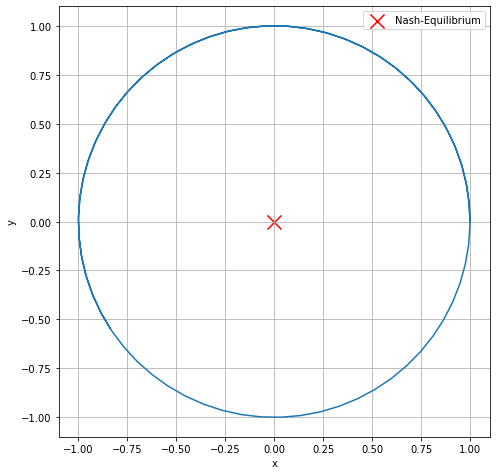

In [ ]:
# Ihr Code

plt.figure(figsize=(7, 7))

t_arr = np.linspace(0, 10, 100)
plt.plot(np.cos(t_arr), np.sin(t_arr))
plt.scatter(0, 0, marker="x", c="r", s=200, label="Nash-Equilibrium")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()


**(Ihre Antwort)**

Die $x$- und $y$-Koordinaten kreisen gleichmäßig und mit gleichem Abstand um das Nash-Equilibrium. Auffällig ist, dass dieses zu keinem Zeitpunkt angenommen wird, da beide Komponenten zu jedem Zeitpunkt versuchen, die beste Strategie zu wählen um deren Kostenfunktion zu minimieren. Dadurch ergibt sich eine Kreisbahn, wobei der Abstand zum Nash-Equilibrium von den Anfangswerten abhängt. 

(4) Macht es einen Unterschied, andere Anfangswerte für $x(t)$ und $y(t)$ zu wählen? Kann dadurch das Nash-Equilibrium erreicht werden?

**(Ihre Antwort)**

Das Nash-Equilibrium kann nur für die Anfangswerte $x(0) = 0$ und $y(0) = 0$ erreicht werden. Dadurch sieht man sehr klar, dass die optimale Strategie nicht immer zum optimalen Ausgang führt, wenn Vorbedingungen festgelegt worden sind.  

## Übung 12.3: Conditional Wasserstein GAN

## Übung 12.4: Zusatzaufgaben

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=522523eb-7d8e-4aea-bf49-3d02d36c4115' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>